In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import sys 
sys.path.append("..")
from kinematics.utils.util_fk import * 
print("Done.")

Done.


In [3]:
def convert_from_uvd(u, v, d):
    pxToMetre = 1
    focalx = 642.346680
    focaly =  644.245300
    cx = 324.860555
    cy = 257.557426
    d *= pxToMetre
    x_over_z = (cx - u) / focalx
    y_over_z = (cy - v) / focaly
    z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z
    return x, y, z

def get_pointcloud(depth, intrinsics):
  """Get 3D pointcloud from perspective depth image.
  Args:
    depth: HxW float array of perspective depth in meters.
    intrinsics: 3x3 float array of camera intrinsics matrix.
  Returns:
    points: HxWx3 float array of 3D points in camera coordinates.
  """
  height, width = depth.shape
  xlin = np.linspace(0, width - 1, width)
  ylin = np.linspace(0, height - 1, height)
  px, py = np.meshgrid(xlin, ylin)
  px = (px - intrinsics[0, 2]) * (depth / intrinsics[0, 0])
  py = (py - intrinsics[1, 2]) * (depth / intrinsics[1, 1])
  points = np.float32([px, py, depth]).transpose(1, 2, 0)
  return points

def get_heightmap(points, bounds, pixel_size):
  """Get top-down (z-axis) orthographic heightmap image from 3D pointcloud.
  Args:
    points: HxWx3 float array of 3D points in world coordinates.
    colors: HxWx3 uint8 array of values in range 0-255 aligned with points.
    bounds: 3x2 float array of values (rows: X,Y,Z; columns: min,max) defining
      region in 3D space to generate heightmap in world coordinates.
    pixel_size: float defining size of each pixel in meters.
  Returns:
    heightmap: HxW float array of height (from lower z-bound) in meters.
    colormap: HxWx3 uint8 array of backprojected color aligned with heightmap.
  """
  width = int(np.round((bounds[0, 1] - bounds[0, 0]) / pixel_size))
  height = int(np.round((bounds[1, 1] - bounds[1, 0]) / pixel_size))
  heightmap = np.zeros((height, width), dtype=np.float32)
  # Filter out 3D points that are outside of the predefined bounds.
  ix = (points[Ellipsis, 0] >= bounds[0, 0]) & (points[Ellipsis, 0] < bounds[0, 1]) # Range of the X
  iy = (points[Ellipsis, 1] >= bounds[1, 0]) & (points[Ellipsis, 1] < bounds[1, 1]) # Range of the Y
  iz = (points[Ellipsis, 2] >= bounds[2, 0]) & (points[Ellipsis, 2] < bounds[2, 1]) # Range of the Z 
  valid = ix & iy & iz
  points = points[valid]
  points.shape
  # Sort 3D points by z-value, which works with array assignment to simulate
  # z-buffering for rendering the heightmap image.
  iz = np.argsort(points[:, -1])
  points = points[iz]
  px = np.int32(np.floor((points[:, 0] - bounds[0, 0]) / pixel_size))
  py = np.int32(np.floor((points[:, 1] - bounds[1, 0]) / pixel_size))
  px = np.clip(px, 0, width - 1)
  py = np.clip(py, 0, height - 1)
  heightmap[py, px] = points[:, 2] - bounds[2, 0] # Depth value 
  return heightmap


def transform_pointcloud(points, transform):
  """Apply rigid transformation to 3D pointcloud.

  Args:
    points: HxWx3 float array of 3D points in camera coordinates.
    transform: 4x4 float array representing a rigid transformation matrix.

  Returns:
    points: HxWx3 float array of transformed 3D points.
  """
  padding = ((0, 0), (0, 0), (0, 1))
  homogen_points = np.pad(points.copy(), padding,
                          'constant', constant_values=1)
  for i in range(3):
    points[Ellipsis, i] = np.sum(transform[i, :] * homogen_points, axis=-1)
  return points

intrinsic = np.array([[642.346680, 0, 324.860555], 
                      [0,644.245300, 257.557426],
                      [0,0,0]])


(0.0, 0.0, 0.0)
(-0.07856742013183861, 0.23570226039551584, 0.1111111111111111)
(-0.15713484026367722, 0.4714045207910317, 0.2222222222222222)
(-0.23570226039551578, 0.7071067811865475, 0.3333333333333333)
(-0.31426968052735443, 0.9428090415820634, 0.4444444444444444)
(-0.3928371006591929, 1.1785113019775793, 0.5555555555555556)
(-0.47140452079103157, 1.414213562373095, 0.6666666666666666)
(-0.54997194092287, 1.6499158227686106, 0.7777777777777777)
(-0.6285393610547089, 1.8856180831641267, 0.8888888888888888)
(-0.7071067811865474, 2.121320343559643, 1.0)


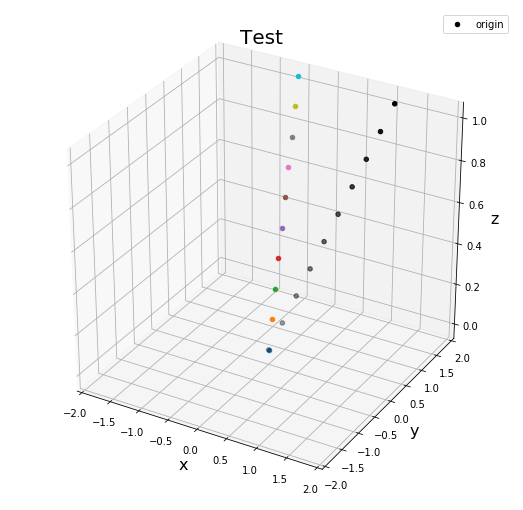

In [3]:
rot_x_mat = rot_z(np.deg2rad(45))
x= np.linspace(start=0,stop=1, num=10)
y= np.linspace(start=0, stop=2, num=10)
z= np.linspace(start=0, stop=1, num=10)

fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
for x_point, y_point, z_point in zip(x,y,z):
    xyz_point = np.array([x_point, y_point, z_point])
    new_xyz_point = np.matmul(rot_x_mat,xyz_point)
    print(new_xyz_point[0], new_xyz_point[1], new_xyz_point[2])
    ax.scatter(new_xyz_point[0], new_xyz_point[1], new_xyz_point[2])
ax.scatter(x,y,z, color='k', label="origin")
plt.legend()
ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("y",fontsize=16)
ax.set_zlabel("z", fontsize=16)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
# ax.set_zlim()
# ax.view_init(0,0)
# ax.view_init(-45,0)

# ax.set_zlim(0,1)
plt.title("Test", fontsize=20)
plt.show()

In [4]:
rot_y_mat = Rotation_Y(np.deg2rad(45))
trans_mat = Translation(x=0, y=0.18, z=1.45)
homo_mat = HT_matrix(Rotation=rot_y_mat, Position=trans_mat)
homo_inv_mat = np.linalg.inv(homo_mat)

orthograph_mat_trans =  Translation(x=0, y=0.6, z=1.55)
orthograph_mat_rot_y_mat = Rotation_Y(np.deg2rad(90))
orthograph_homo_mat = HT_matrix(Rotation=orthograph_mat_rot_y_mat, 
                                Position=orthograph_mat_trans)


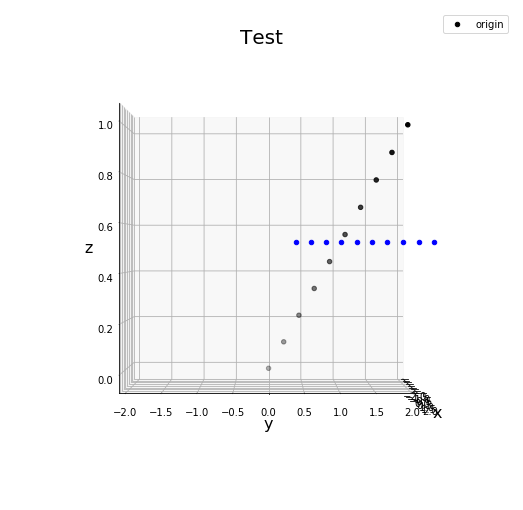

In [5]:
x= np.linspace(start=0,stop=1, num=10)
y= np.linspace(start=0, stop=2, num=10)
z= np.linspace(start=0, stop=1, num=10)

fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
for x_point, y_point, z_point in zip(x,y,z):
    xyz_point = np.array([x_point, y_point, z_point, 1])
    new_xyz_point = np.matmul(orthograph_homo_mat,np.matmul(homo_inv_mat,xyz_point))
    ax.scatter(new_xyz_point[0], new_xyz_point[1], new_xyz_point[2], color="b")
ax.scatter(x,y,z, color='k', label="origin")
plt.legend()
ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("y",fontsize=16)
ax.set_zlabel("z", fontsize=16)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
# ax.set_zlim()
ax.view_init(0,0)
# ax.view_init(-45,0)

# ax.set_zlim(0,1)
plt.title("Test", fontsize=20)
plt.show()


In [6]:
orthograph_mat_trans =  Translation(x=0, y=0.35, z=1.3)
orthograph_mat_rot_y_mat = Rotation_Y(np.math.pi/6)
orthograph_homo_mat = HT_matrix(Rotation=orthograph_mat_rot_y_mat, 
                                Position=orthograph_mat_trans)

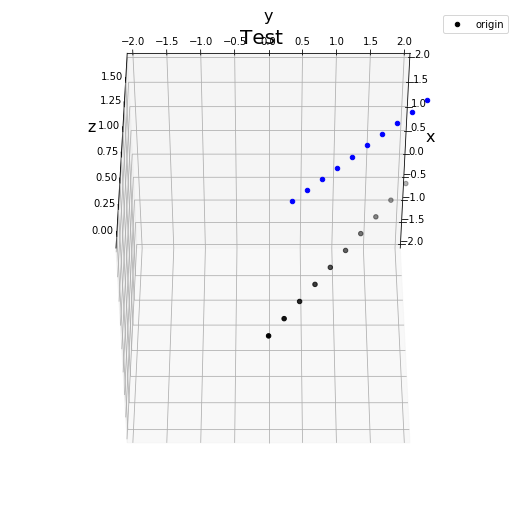

In [7]:
x= np.linspace(start=0,stop=1, num=10)
y= np.linspace(start=0, stop=2, num=10)
z= np.linspace(start=0, stop=1, num=10)

fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
for x_point, y_point, z_point in zip(x,y,z):
    xyz_point = np.array([x_point, y_point, z_point, 1])
    new_xyz_point = np.matmul(orthograph_homo_mat,xyz_point)
    ax.scatter(new_xyz_point[0], new_xyz_point[1], new_xyz_point[2], color="b")
ax.scatter(x,y,z, color='k', label="origin")
plt.legend()
ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("y",fontsize=16)
ax.set_zlabel("z", fontsize=16)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
# ax.set_zlim()
# ax.view_init(0,0)
ax.view_init(-45,0)

# ax.set_zlim(0,1)
plt.title("Test", fontsize=20)
plt.show()

In [8]:
data = np.load("./depth_data/depth_multi_objs.npy")


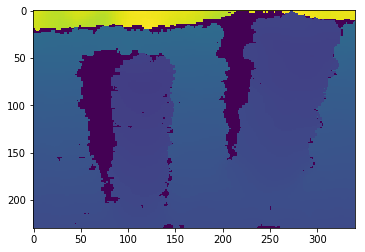

In [9]:
plt.imshow(data[150:-100,250:-50])

In [10]:
rot_y_mat = Rotation_Y(np.deg2rad(np.math.pi/6))
trans_mat = Translation(x=0.35, y=0.134, z=1.3)
homo_mat = HT_matrix(Rotation=rot_y_mat, Position=trans_mat)
homo_inv_mat = np.linalg.inv(homo_mat)

orthograph_mat_trans =  Translation(x=0.6, y=0.134, z=1.3)
orthograph_mat_rot_y_mat = Rotation_Y(-np.math.pi/2)
orthograph_homo_mat = HT_matrix(Rotation=orthograph_mat_rot_y_mat, 
                                Position=orthograph_mat_trans)

In [11]:
x_lst = [] 
y_lst = []
z_lst = []
new_xyz_point_lst=[]
data = data[150:-100,250:-50]
for width_idx in range(data.shape[0]):
    for height_idx in range(data.shape[1]):
        x, y, z = convert_from_uvd(width_idx, height_idx, data[width_idx][height_idx]*0.001)
        x_lst.append(x) 
        y_lst.append(y)
        z_lst.append(z)
        xyz_point = np.array([x, y, z,1])
        new_xyz_point = np.matmul(orthograph_homo_mat,(np.matmul(homo_inv_mat,xyz_point)))
        new_xyz_point_lst.append(new_xyz_point)



In [12]:
new_xyz_point_lst=np.array(new_xyz_point_lst)

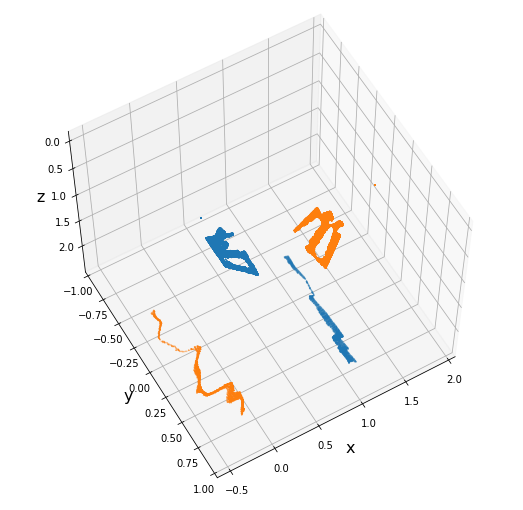

In [13]:
fig = plt.figure(figsize=(9,9))
ax = fig.gca(projection='3d')
ax.scatter(x_lst, y_lst, z_lst, s=0.1)
ax.scatter(new_xyz_point_lst[:,0], new_xyz_point_lst[:,1], new_xyz_point_lst[:,2],s=0.1)
ax.set_xlabel("x", fontsize=16)
ax.set_ylabel("y",fontsize=16)
ax.set_zlabel("z", fontsize=16)
ax.set_ylim(-1,1)
ax.view_init(-90-np.rad2deg(np.math.pi/6),)
# ax.view_init(0,-90)

(1000, 1000)


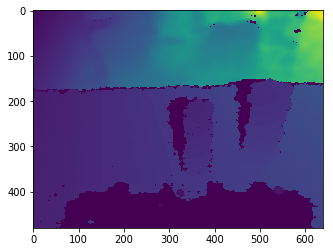

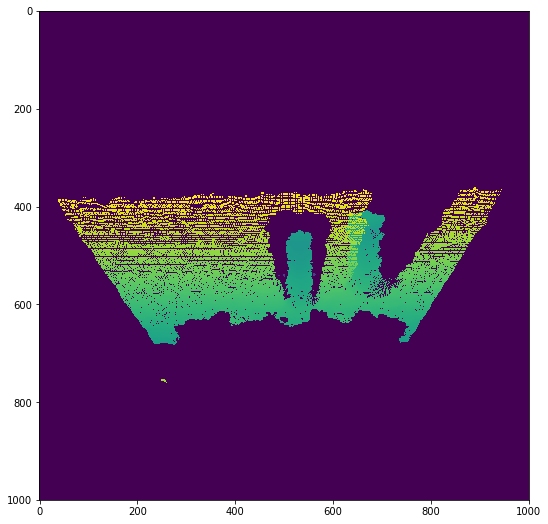

In [352]:
data = np.load("./depth_data/depth_multi_objs.npy")
# data = data[150:-100,250:-50]
points = get_pointcloud(data*0.001, intrinsic)
plt.imshow(points[:,:,0]+points[:,:,1]+points[:,:,2])
bounds = np.array([[-0.5,0.5], 
                   [-0.5,0.5],
                   [-0,2]])

height_map = get_heightmap(points, bounds, pixel_size=0.001)
fig = plt.figure(figsize=(9,9))
print(height_map.shape)
plt.imshow(height_map)


(1000, 1000)


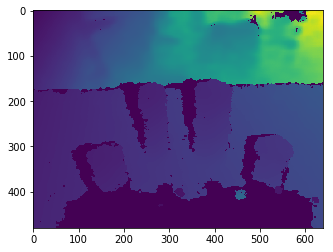

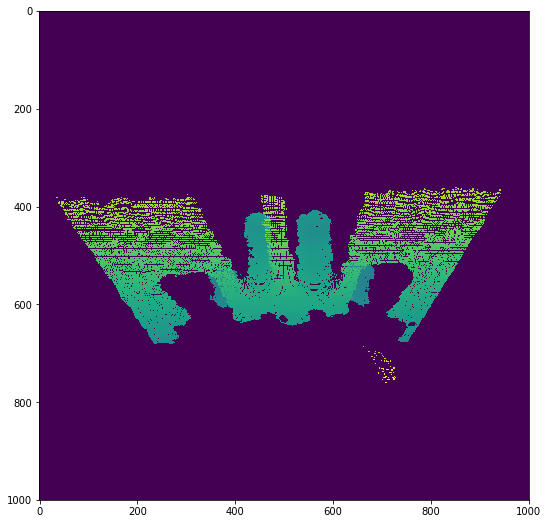

In [353]:
data = np.load("./depth_data/depth_multi_objs_4.npy")
# data = data[150:-100,250:-50]
points = get_pointcloud(data*0.001, intrinsic)
plt.imshow(points[:,:,0]+points[:,:,1]+points[:,:,2])

bounds = np.array([[-0.5,0.5], 
                   [-0.5,0.5],
                   [-0.,2]])

height_map = get_heightmap(points, bounds, pixel_size=0.001)
fig = plt.figure(figsize=(9,9))
print(height_map.shape)
plt.imshow(height_map)



(1000, 1000)


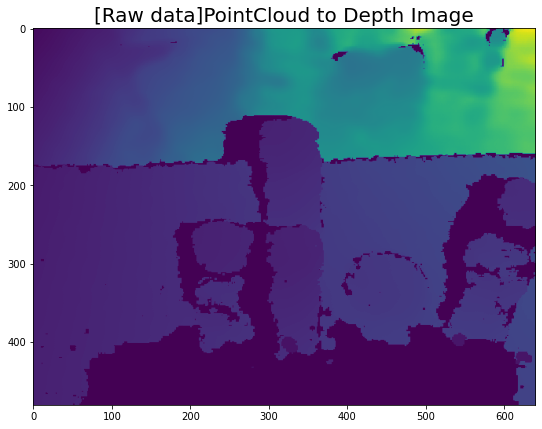

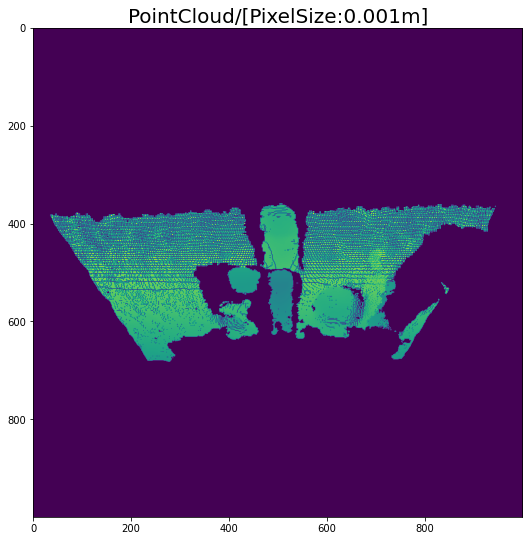

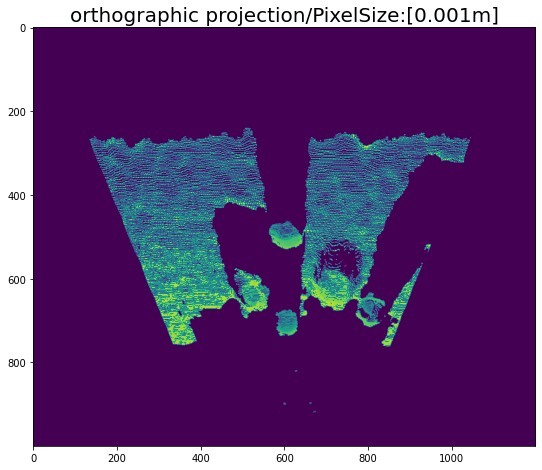

In [5]:
data = np.load("./depth_data/depth_multi_objs_2.npy")
points = get_pointcloud(data*0.001, intrinsic)
fig = plt.figure(figsize=(9,9))
plt.title("[Raw data]PointCloud to Depth Image", fontsize=20)
plt.imshow(points[:,:,0]+points[:,:,1]+points[:,:,2])
bounds = np.array([[-0.5,0.5], 
                   [-0.5,0.5],
                   [-0,2]])

height_map = get_heightmap(points, bounds, pixel_size=0.001)
fig = plt.figure(figsize=(9,9))
print(height_map.shape)
plt.title("PointCloud/[PixelSize:0.001m]", fontsize=20)
plt.imshow(height_map)

rot_y_mat = Rotation_X(-np.math.pi/4)
trans_mat = Translation(x=-0., y=0.0, z=0)
homo_mat = HT_matrix(Rotation=rot_y_mat, Position=trans_mat)
homo_inv_mat = np.linalg.inv(homo_mat)

new_points = transform_pointcloud(points, homo_inv_mat)
# fig = plt.figure(figsize=(9,9))
# plt.imshow(new_points[:,:,0]+new_points[:,:,1]+new_points[:,:,2])

new_bounds = np.array([[-0.6,0.6], 
                   [-1.,0],
                   [-0,1]])


new_height_map = get_heightmap(new_points, new_bounds, pixel_size=0.001)
fig = plt.figure(figsize=(9,9))
plt.title("orthographic projection/PixelSize:[0.001m]", fontsize=20)
plt.imshow(new_height_map)

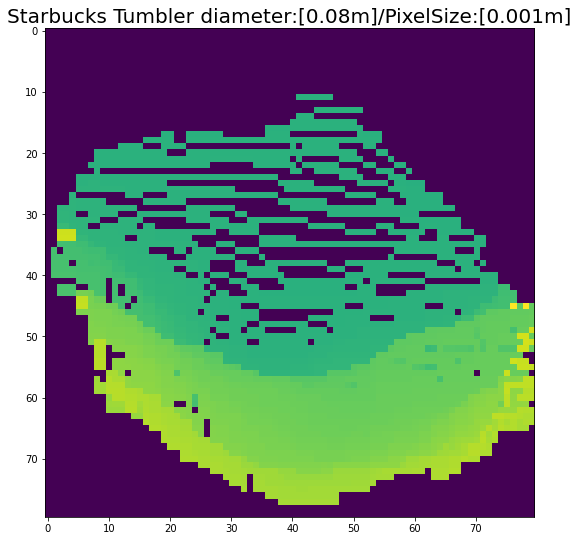

In [6]:
plt.figure(figsize=(9,9))
plt.title("Starbucks Tumbler diameter:[0.08m]/PixelSize:[0.001m]",fontsize=20)
plt.imshow(new_height_map[452:532,562:642])

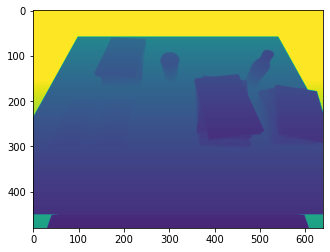

In [162]:
img = plt.imread("./depth_data/depth0_1_640.png")
plt.imshow(img)


(600, 600)


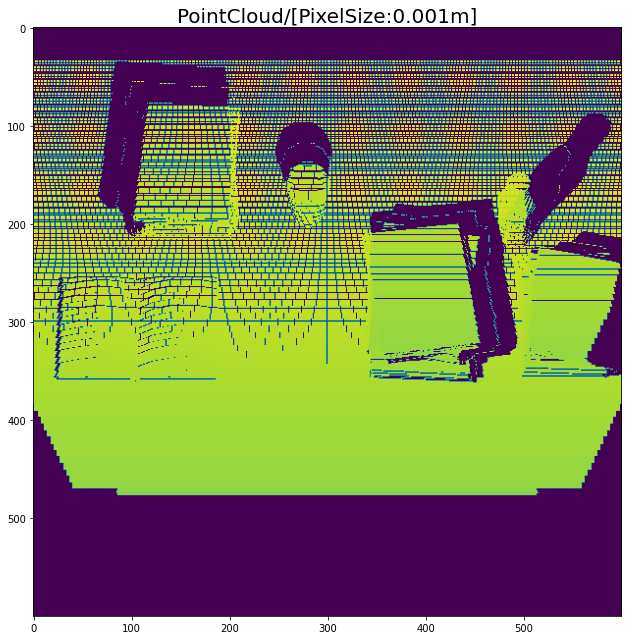

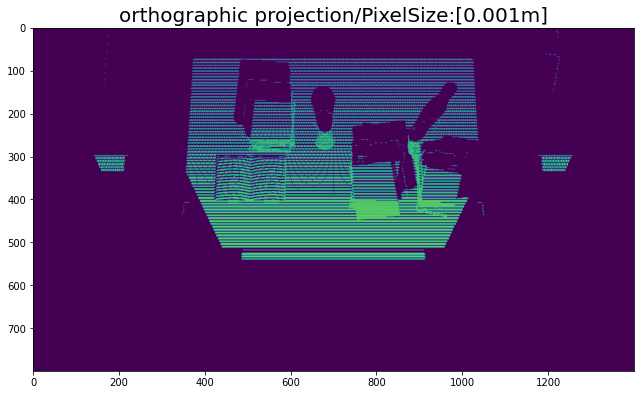

In [188]:

unity_intrinsic = np.array([[387.386, 0, 320], 
                      [0,387.386, 240],
                      [0,0,0]])

points = get_pointcloud(img*1, unity_intrinsic)

# fig, ax = plt.subplots(figsize=(9, 9))
# plt.title("[Raw data]PointCloud to Depth Image", fontsize=20)
# ax.imshow(points[:,:,0]+points[:,:,1]+points[:,:,2])
# plt.tight_layout()

bounds = np.array([[-0.3,0.3], 
                   [-0.3,0.3],
                   [-1,1]])

height_map = get_heightmap(points, bounds, pixel_size=0.001)
print(height_map.shape)
fig, ax = plt.subplots(figsize=(9, 9))
plt.title("PointCloud/[PixelSize:0.001m]", fontsize=20)
ax.imshow(height_map)
plt.tight_layout()


rot_y_mat = Rotation_X(-np.math.pi/3)
trans_mat = Translation(x=-0., y=0, z=0)
homo_mat = HT_matrix(Rotation=rot_y_mat, Position=trans_mat)
homo_inv_mat = np.linalg.inv(homo_mat)

new_points = transform_pointcloud(points, homo_inv_mat)
# fig = plt.figure(figsize=(9,9))
# plt.imshow(new_points[:,:,0]+new_points[:,:,1]+new_points[:,:,2])

new_bounds = np.array([[-0.7,0.7], 
                   [-0.7,0.1],
                   [-1,1]])


new_height_map = get_heightmap(new_points, new_bounds, pixel_size=0.001)
fig, ax = plt.subplots(figsize=(9, 9))
plt.title("orthographic projection/PixelSize:[0.001m]", fontsize=20)
ax.imshow(new_height_map)
plt.tight_layout()



(700, 700)


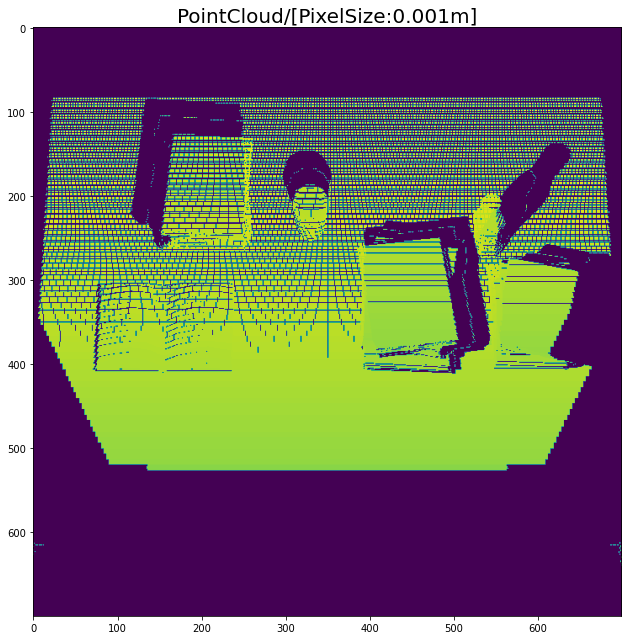

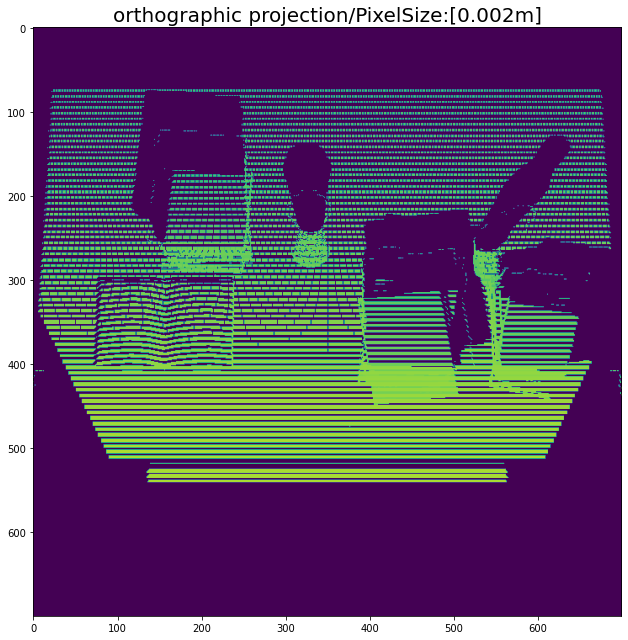

In [251]:

unity_intrinsic = np.array([[387.386, 0, 320], 
                      [0,387.386, 240],
                      [0,0,0]])

points = get_pointcloud(img*2, unity_intrinsic)

# fig, ax = plt.subplots(figsize=(9, 9))
# plt.title("[Raw data]PointCloud to Depth Image", fontsize=20)
# ax.imshow(points[:,:,0]+points[:,:,1]+points[:,:,2])
# plt.tight_layout()

bounds = np.array([[-0.7,0.7], 
                   [-0.7,0.7],
                   [-2,2]])

height_map = get_heightmap(points, bounds, pixel_size=0.002)
print(height_map.shape)
fig, ax = plt.subplots(figsize=(9, 9))
plt.title("PointCloud/[PixelSize:0.001m]", fontsize=20)
ax.imshow(height_map)
plt.tight_layout()


rot_y_mat = Rotation_X(-np.math.pi/3)
trans_mat = Translation(x=-0., y=0, z=0)
homo_mat = HT_matrix(Rotation=rot_y_mat, Position=trans_mat)
homo_inv_mat = np.linalg.inv(homo_mat)

new_points = transform_pointcloud(points, homo_inv_mat)
# fig = plt.figure(figsize=(9,9))
# plt.imshow(new_points[:,:,0]+new_points[:,:,1]+new_points[:,:,2])

new_bounds = np.array([[-0.7,0.7], 
                   [-1.4,0.],
                   [-2,2]])


new_height_map = get_heightmap(new_points, new_bounds, pixel_size=0.002)
fig, ax = plt.subplots(figsize=(9, 9))
plt.title("orthographic projection/PixelSize:[0.002m]", fontsize=20)
ax.imshow(new_height_map)
plt.tight_layout()



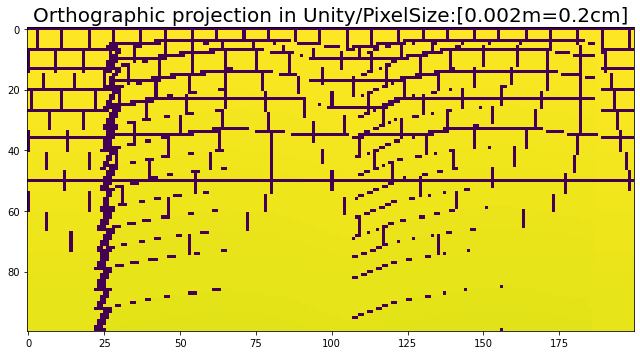

In [246]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(height_map[300:400,50:250])
plt.title("Orthographic projection in Unity/PixelSize:[0.002m=0.2cm]", fontsize=20)
plt.tight_layout()

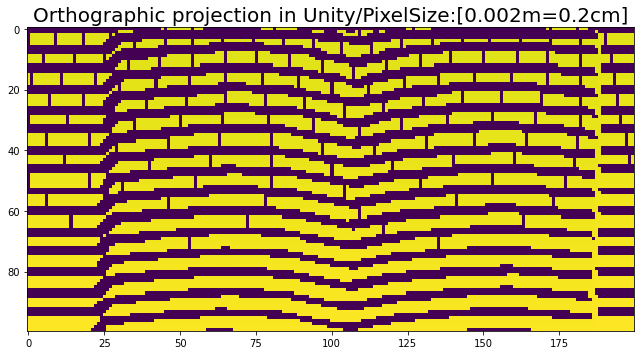

In [252]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.imshow(new_height_map[300:400,50:250])
plt.title("Orthographic projection in Unity/PixelSize:[0.002m=0.2cm]", fontsize=20)
plt.tight_layout()